In [ ]:
# Clone the Darknet repository from GitHub
!git clone https://github.com/AlexeyAB/darknet.git

# Please refer to the repository documentation for further instructions and usage details:
# https://github.com/AlexeyAB/darknet#how-to-train-to-detect-your-custom-objects

Cloning into 'darknet'...
remote: Enumerating objects: 15521, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 15521 (delta 0), reused 5 (delta 0), pack-reused 15514
Receiving objects: 100% (15521/15521), 14.19 MiB | 20.50 MiB/s, done.
Resolving deltas: 100% (10412/10412), done.


In [ ]:
# Importing the necessary library 'drive' from the package 'google.colab'
from google.colab import drive

# Mounting the Google Drive to the Colab runtime
# This allows access to files and directories in the Google Drive
drive.mount('/content/gdrive')

In [ ]:
#This line of code installs the FiftyOne library using pip.
#FiftyOne is a Python package that provides interactive exploration, analysis, and visualization of datasets for computer vision tasks.
!pip install fiftyone

In [ ]:
import random  # Importing the random module for generating random numbers
import fiftyone as fo  # Importing the fiftyone library for working with datasets and models
import fiftyone.zoo as foz  # Importing the fiftyone.zoo module for accessing pre-trained models
from fiftyone import ViewField as F  # Importing the ViewField class from the fiftyone module

In [ ]:
# Define a list of all COCO classes for object relabeling
'''
relabeling_classes = [
    "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train",
    "truck", "boat", "traffic light", "fire hydrant", "stop sign",
    "parking meter", "bench", "bird", "cat", "dog", "horse", "sheep",
    "cow", "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella",
    "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball",
    "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
    "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon",
    "bowl", "banana", "apple", "sandwich", "orange", "broccoli", "carrot",
    "hot dog", "pizza", "donut", "cake", "chair", "couch", "potted plant",
    "bed", "dining table", "toilet", "tv", "laptop", "mouse", "remote",
    "keyboard", "cell phone", "microwave", "oven", "toaster", "sink",
    "refrigerator", "book", "clock", "vase", "scissors", "teddy bear",
    "hair drier", "toothbrush"
]
relabeling_classes = [
    "bird", "cat", "dog", "horse", "sheep",
    "cow", "elephant", "bear", "zebra", "giraffe"
]

labeling_classes = [
    "bird", "cat", "dog", "horse", "sheep",
    "cow", "elephant", "bear", "zebra", "giraffe"
]
'''
#shrink relabeling classes to 3 for faster training.
relabeling_classes = [
    "cat", "dog", "horse"
]

# this is used to export the class list to the converted yolov4 format data.

labeling_classes = [
    "cat", "dog", "horse"
]

In [ ]:
def dwonload_dataset(class_name, max_samples):

  dataset = foz.load_zoo_dataset( # Load a dataset from the zoo using foz.load_zoo_dataset() function
      "coco-2017",
      splits=["train"],
      classes= class_name,        # Specify the name of the dataset as "coco-2017"
      max_samples= max_samples   # Specify the maximum number of samples to load from the dataset based on the provided max_samples argument
  )
  dataset.persistent = True       # Set the persistent attribute of the dataset to True, indicating that it should be saved and loaded from disk if necessary

  return dataset

In [ ]:
def clone_and_split_test(dataset, class_name):

  class_dataset = dataset.clone()  # Clone the original dataset
  class_dataset.persistent = True  # Set the persistent flag to True, indicating that the cloned dataset should persist in memory

  class_test_dataset = dataset.clone()  # Clone the original dataset
  class_test_dataset.persistent = True  # Set the persistent flag to True, indicating that the cloned dataset should persist in memory

  class_dataset_view = class_dataset.filter_labels("ground_truth", F("label").is_in([class_name])).limit(1000)  # Create a view of the class_dataset, filtered by the given class_name and limited to 1000 samples

  class_test_view = class_test_dataset.filter_labels("ground_truth", F("label").is_in([class_name])).skip(1000)  # Create a view of the class_test_dataset, filtered by the given class_name and skipping the first 1000 samples

  return class_dataset_view.clone(), class_test_view.clone()  # Return the cloned views of the class_dataset and class_test_dataset


In [ ]:
def merge_dataset(dataset, class_name):

  temp1 = dataset.clone()  # Create a clone of the dataset and store it in 'temp1' variable
  temp = temp1.filter_labels("ground_truth", F("label").is_in(["cat"]))  # Filter the dataset to include only samples with the label "cat" in the "ground_truth" field, and store the result in 'temp' variable

  for sample in temp.select_fields('tags').iter_samples(autosave=True):  # Iterate over each sample in 'temp' dataset, selecting only the 'tags' field, and enabling autosave
    sample.set_field('tags', ['train'])  # Set the 'tags' field of the current sample to ['train']

  temp.keep()  # Remove any intermediate data and keep only the modified dataset 'temp'

  return temp.clone()  # Return a clone of the modified dataset 'temp'


In [ ]:
def resize_dataset(dataset, percentage):

  print(len(dataset))  # Print the length of the dataset to check its initial size
  temp = dataset.take(int(len(dataset) * percentage/100))  # Take a portion of the dataset based on the given percentage

  return temp.clone()  # Return a copy of the extracted portion of the dataset


In [ ]:
def resplit(dataset, percentage):

  total_len = len(dataset)  # Calculate the total length of the dataset
  train_len = int(total_len * percentage / 100)  # Calculate the length of the training set based on the percentage
  val_len = total_len - train_len  # Calculate the length of the validation set by subtracting the training set length from the total length

  print('train:', train_len, ' validiation:', val_len, ' total:', total_len)  # Print the lengths of the training set, validation set, and total dataset

  train_set = dataset.limit(train_len)  # Limit the dataset to the length of the training set to create the training set
  val_set = dataset.skip(train_len).limit(val_len)  # Skip the training set length and limit the dataset to the length of the validation set to create the validation set


  for sample in train_set.select_fields('tags').iter_samples(autosave=True):
    sample.set_field('tags', ['train'])  # Set the 'tags' field of each sample in the training set to ['train']

  for sample in val_set.select_fields('tags').iter_samples(autosave=True):
    sample.set_field('tags', ['validation'])  # Set the 'tags' field of each sample in the validation set to ['validation']

  return train_set.clone(), val_set.clone()  # Return the cloned versions of the training set and validation set


In [ ]:
def add_label_error(dataset, percentage, class_name):

  total_len = len(dataset)
  label_error_len = int(total_len * percentage / 100)
  error_free_len = total_len - label_error_len

  # randomly split the dataset into error and error free sets using the given ratio
  label_error_set = dataset.limit(label_error_len)
  error_free_set = dataset.skip(label_error_len).limit(error_free_len)

  # Check if there are three relabeling classes and remove the specified class
  if (len(relabeling_classes)==3):
    relabeling_classes.remove(class_name)

  # Iterate over each sample in the label error set
  for sample in label_error_set.iter_samples(autosave=True):

    # Iterate over each detection in the sample's ground truth
    for detection in sample.ground_truth.detections:
      # Generate a new label randomly from the relabeling classes
      new_label = random.choice(relabeling_classes)
      # Check if the detection label is the specified class
      if detection.label == class_name:
        # Assign the new label to the detection
        detection.label = new_label
        # Print the new label
        print(new_label)

    # Save the modified sample
    sample.save()

  # Save the label error set
  label_error_set.save()

  # Print the number of images with label errors
  print("number of images with label errors = ", len(label_error_set))

  # Concatenate the label error set and error-free set
  concat_data_set = label_error_set.concat(error_free_set)
  # Shuffle the concatenated dataset
  shuffled_data = concat_data_set.shuffle()

  # Check if there are two relabeling classes and insert the specified class at the beginning
  if (len(relabeling_classes)==2):
    relabeling_classes.insert(0, class_name)

  # Return a clone of the shuffled dataset
  return shuffled_data.clone()


In [ ]:
def generateDataset(dataset, class_name, size, resplit_percent):

  resized_dataset = resize_dataset(dataset, size)  # Resizing the original dataset to a specific size
  label_error_dataset = add_label_error(resized_dataset, error_rate, class_name)  # Adding label errors to the resized dataset
  train_set, val_set = resplit(label_error_dataset, resplit_percent)  # Splitting the dataset into training and validation sets

  return train_set, val_set


In [ ]:
class_name = 'cat'                                                    #select the desired class to be downloaded from coco data-set
max_samples = 4000                                                    #define the number of images.
dataset = dwonload_dataset(class_name, max_samples)                   #downloading the data-set.

# split the datase into 1000 images as training set and 3000 as test set.
# the test set should be used to test all the ML models.

train_dataset, test_data = clone_and_split_test(dataset, class_name)


# step 2- Prepare training and valiation data sets

In [ ]:

#the foolowing code will produce the desired data set
#change the variabels of size, resplit.., error rate to produce the desired data set


exp_name = "E2D30"

size = 30                               # Represents the size of the dataset, will be used for resizing
                                        # the dataset by a percentage value.

resplit_precent = 80                    # Determines the percentage of the original dataset to be used for
                                        # training data. The remaining percentage will be used for validation.

error_rate = 0                          # Represents the error rate to be added to the dataset.

train_data, val_data = generateDataset(train_dataset, class_name, size, resplit_precent)
                                        # Calls the function generateDataset to generate the training and
                                        # validation datasets. The parameters passed are train_dataset (the
                                        # original dataset), class_name (the name of the class), size (used
                                        # for resizing), and resplit_precent (used for splitting the dataset).


In [ ]:
#the foolowing code will print a report showing the main modification on the data set.

'''
print("length of training set = ",len(train_data))    # Prints the length of the training set
print("length of validation set = ",len(val_data))    # Prints the length of the validation set
print("length of test set = ",len(test_data))          # Prints the length of the test set
print("********************************************")

i = 0                                                 # Initializes a counter variable i with 0

for sample in val_data:                               # Iterates through each sample in the val_data
  i += 1                                              # Increments the counter i by 1 for each iteration

  #print(i , '- ', sample.ground_truth.detections, ' - ', sample.tags)
  # The above line is commented out, so it does not execute

  print(i , '- ', sample.ground_truth.detections[0].label, ' - ', sample.tags)
  # Prints the index (i), the label of the first detection in the ground truth of the sample, and the tags of the sample

print("********************************************")
print("length of training set = ",len(train_data))    # Prints the length of the training set
print("length of validation set = ",len(val_data))    # Prints the length of the validation set

'''

The folder structure for the Darknet YOLOv4 data is as follows:


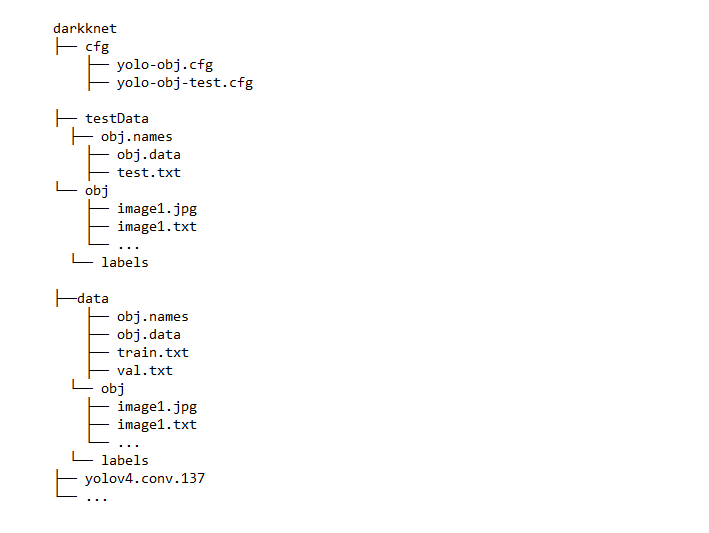

In [ ]:

# The following code will clear the data and cfg folder from unnecessary files

%cp -r /content/darknet/data /content/darknet/data_backup         # Creates a backup of the 'data' directory
%rm -rf /content/darknet/data/                                    # Deletes the 'data' directory
%mkdir -p /content/darknet/data/                                  # Recreates the 'data' directory
%cp -r /content/darknet/data_backup/labels /content/darknet/data  # Copies the 'labels' directory from the backup to the new 'data' directory
%rm -rf /content/darknet/cfg                                      # Deletes the 'cfg' directory
%mkdir -p /content/darknet/cfg                                    # Creates an empty 'cfg' directory
%rm -rf /content/darknet/data_backup                              # Deletes the backup of the 'data' directory


In [ ]:

#convering training data set to yolov4 format and saving to /darknet/data

# Set the export directory where the dataset will be saved
export_dir = "/content/darknet/data"

# Set the path to the data folder
data_path = "/content/darknet/data/obj"

# Set the path to the labels folder
labels_path = "/content/darknet/data/obj"

# Set the path to the text file containing image paths
images_path = "/content/darknet/train.txt"

# Specify the label field name in the dataset or view
label_field = "ground_truth"

# Specify the dataset or view to export
dataset_or_view = train_data

# Export the dataset to the specified export directory
dataset_or_view.export(
    export_dir=export_dir,
    dataset_type=fo.types.YOLOv4Dataset,
    label_field=label_field,
    classes=labeling_classes,
    data_path=data_path,
    labels_path=labels_path,
    images_path=images_path,
)

# Move the train.txt file to the data folder
!mv /content/darknet/train.txt /content/darknet/data/train.txt

In [ ]:

#convering validiation data set to yolov4 format and saving to /darknet/data

export_dir = "/content/darknet/data"
data_path = "/content/darknet/data/obj"
labels_path = "/content/darknet/data/obj"
images_path = "/content/darknet/val.txt"
label_field = "ground_truth"

# The dataset or view to export
dataset_or_view = val_data

# Export the dataset
dataset_or_view.export(
    export_dir=export_dir,
    dataset_type=fo.types.YOLOv4Dataset,
    label_field=label_field,
    classes= labeling_classes,
    data_path = data_path,
    labels_path = labels_path,
    images_path = images_path,
)

!mv /content/darknet/val.txt /content/darknet/data/val.txt

In [ ]:
# At this stage, the following three files are required:

# 1. yolo-obj.cfg: This file serves as the configuration file for training.
!wget -P /content/darknet/cfg https://github.com/adammuntasir/Data-Annotation-Process-and-ML-Model-Performance/raw/main/Config/cfg/yolo-obj.cfg
# 2. yolo-obj-test.cfg: This file is the configuration file specifically designed for testing.
!wget -P /content/darknet/cfg https://github.com/adammuntasir/Data-Annotation-Process-and-ML-Model-Performance/raw/main/Config/cfg/yolo-obj-test.cfg
# 3. obj.data: This file stores essential information and settings.
!wget -P /content/darknet/data https://github.com/adammuntasir/Data-Annotation-Process-and-ML-Model-Performance/raw/main/Config/obj.data


In [ ]:
# will show folders sizes.
!du -sh /content/darknet/data
!du -sh /content/data/{exp_name}
!du -sh /content/terminal/{exp_name}.zip

In [ ]:
# the content of the obj.data file is as follows:
#classes = 3                    # number of classes should matach across all the dtatsets.
#train  = data/train.txt
#valid  = data/val.txt
#names = data/obj.names
#backup = /mimer/NOBACKUP/groups/naiss2023-22-457/Experiments_results/E3D10L0/weights     # this line will specify the path where the trained model will be saved.

#specify the number of classes
!sed -i 's/^classes = .*/classes = 3/' /content/darknet/data/obj.data

#change the backup path to your desired path.
!sed -i 's@^backup = /mimer/NOBACKUP/groups/naiss2023-22-457/.*@backup = /mimer/NOBACKUP/groups/naiss2023-22-457/Experiments_results/{exp_name}/weights@' /content/darknet/data/obj.data

#print the updated file.
!cat /content/darknet/data/obj.data


#Export training and validiation sets - optional.
If you're planning to train on a different high-performance computing (HPC) platform rather than Google Colab, you can use the following three cells to export the dataset to your Google Drive. Then, download and unzip it to your preferred location.

In [ ]:
!mkdir -p /content/terminal
!mkdir -p /content/data/{exp_name}/data
!mkdir -p /content/data/{exp_name}/cfg
!mkdir -p /content/data/{exp_name}/weights
!cp -r /content/darknet/data /content/data/{exp_name}
!cp -r /content/darknet/cfg /content/data/{exp_name}
#!mv /content/data/{exp_name}.zip /content/terminal/{exp_name}
#!cp -r /content/terminal/{exp_name}.zip /content/gdrive/MyDrive/Colab_Notebooks/Experiments_results/

In [ ]:
!pwd
%cd /content/data/
!zip -r /content/terminal/{exp_name}.zip ./{exp_name}/*
%cd /content/darknet/data


In [ ]:

# Fill in the desired path in your Google Drive.
!cp -r /content/terminal/{exp_name}.zip /content/gdrive/MyDrive/Colab_Notebooks/Experiments_results/


In [ ]:
#!rm -rf /content/data/{exp_name}
#!rm -rf /content/terminal/{exp_name}.zip

#PREPARE TEST DATA
the test data is made of one class "cat" an consist of 3000 images.

In [ ]:
!rm -rf /content/darknet/testData
!rm -rf /content/darknet/cfg
!rm -rf /content/data/testData
!rm -rf /content/terminal/testData.zip
!mkdir -p /content/darknet/testData/labels/ && cp -r /content/darknet/data/labels /content/darknet/testData/
!mkdir -p /content/darknet/cfg

In [ ]:

#convering test data set to yolov4 format and saving to /darknet/testData
export_dir = "/content/darknet/testData"
data_path = "/content/darknet/testData/obj"
labels_path = "/content/darknet/testData/obj"
images_path = "/content/darknet/test.txt"
label_field = "ground_truth"  # for example

# The dataset or view to export
dataset_or_view = test_data

# Export the dataset
dataset_or_view.export(
    export_dir=export_dir,
    dataset_type=fo.types.YOLOv4Dataset,
    label_field=label_field,
    classes= labeling_classes,
    data_path = data_path,
    labels_path = labels_path,
    images_path = images_path,
)

!mv /content/darknet/test.txt /content/darknet/testData/test.txt

In [ ]:
# At this stage, the following three files are required:

# 1. yolo-obj.cfg: This file serves as the configuration file for training.
!wget -P /content/darknet/cfg https://github.com/adammuntasir/Data-Annotation-Process-and-ML-Model-Performance/raw/main/Config/cfg/yolo-obj.cfg
# 2. yolo-obj-test.cfg: This file is the configuration file specifically designed for testing.
!wget -P /content/darknet/cfg https://github.com/adammuntasir/Data-Annotation-Process-and-ML-Model-Performance/raw/main/Config/cfg/yolo-obj-test.cfg
# 3. obj.data: This file stores essential information and settings.
!wget -P /content/darknet/testData https://github.com/adammuntasir/Data-Annotation-Process-and-ML-Model-Performance/raw/main/Config/obj.data

In [ ]:
# will show the folder size
!du -sh /content/darknet/testData
!du -sh /content/data/testData
!du -sh /content/terminal/testData.zip

In [ ]:

exp_name = "testData"

!sed -i 's/^classes = .*/classes = 3/' /content/darknet/testData/obj.data
!sed -i 's@^train  =.*@train  = testData/test.txt@' /content/darknet/testData/obj.data
!sed -i 's@^valid  =.*@valid  = testData/test.txt@' /content/darknet/testData/obj.data
!sed -i 's@^names = .*@names = testData/obj.names@' /content/darknet/testData/obj.data
!sed -i 's@^backup = /mimer/NOBACKUP/groups/naiss2023-22-457/.*@backup = /mimer/NOBACKUP/groups/naiss2023-22-457/Experiments_results/{exp_name}/weights@' /content/darknet/testData/obj.data
!cat /content/darknet/testData/obj.data

classes = 3
train  = testData/test.txt
valid  = testData/test.txt
names = testData/obj.names
backup = /mimer/NOBACKUP/groups/naiss2023-22-457/Experiments_results/testData/weights

#Export test data set -optional.
use the following three cells to export the dataset to your Google Drive. Then, download and unzip it to your preferred location.

In [ ]:
!mkdir -p /content/terminal
!mkdir -p /content/data/{exp_name}/{exp_name}
!mkdir -p /content/data/{exp_name}/cfg
!mkdir -p /content/data/{exp_name}/weights
!cp -r /content/darknet/testData /content/data/{exp_name}
!cp -r /content/darknet/cfg /content/data/{exp_name}
#!mv /content/data/{exp_name}.zip /content/terminal/{exp_name}
#!cp -r /content/terminal/{exp_name}.zip /content/gdrive/MyDrive/Colab_Notebooks/Experiments_results/

In [ ]:
!pwd
%cd /content/data/
!zip -r /content/terminal/{exp_name}.zip ./{exp_name}/*
%cd /content/darknet/data

In [ ]:
!cp -r /content/terminal/{exp_name}.zip /content/gdrive/MyDrive/Colab_Notebooks/Experiments_results/

# Configuring cfg Files for Training and Testing

In order to train and test your object detector, you will need to make some changes to the `yolo-obj.cfg` file. Follow the instructions below based on the number of classes you have.

## For Training:

1. Open the `yolo-obj.cfg` file and edit it according to your object detector requirements. By default, it is already configured for three object classes. If you have a different number of classes, follow these steps to configure it:

2. Change the values of `batch` and `subdivisions` to:
   ```
   batch = 64
   subdivisions = 16
   ```

3. Set the `width` and `height` to any multiple of 32. The standard value is `416`, but you can experiment with larger values like `608` for potentially improved results. However, note that larger values will slow down the training process. Example:
   ```
   width = 416
   height = 416
   ```

4. Calculate the value of `max_batches` based on the number of classes:
   ```
   max_batches = (# of classes) * 2000
   ```
   Make sure `max_batches` is not less than 6000. For example, if you are training for 1, 2, or 3 classes, set `max_batches` to 6000. However, if you are training for 5 classes, set `max_batches` to 10000.

5. Determine the values of `steps` for learning rate decay:
   ```
   steps = (80% of max_batches), (90% of max_batches)
   ```
   For example, if `max_batches` is 10000, then `steps` would be 8000 and 9000.

6. Calculate the value of `filters` based on the number of classes:
   ```
   filters = (# of classes + 5) * 3
   ```
   For example, if you are training for one class, `filters` would be 18. If you are training for 4 classes, `filters` would be 27.

## For Testing:

1. The `yolo-obj-test.cfg` file is already configured for three classes. If you have a different number of classes, follow these steps:

2. Change the values of `batch` and `subdivisions` to:
   ```
   batch = 1
   subdivisions = 1
   ```

3. The rest of the configuration remains the same for testing.

Make sure to save the changes to the respective configuration files (`yolo-obj.cfg` for training and `yolo-obj-test.cfg` for testing) after making the necessary modifications.

# Download pre-trained YOLOv4 weights and build.
YOLOv4 has already been trained on the COCO dataset, which consists of 80 classes that it can predict. By downloading these pre-trained weights, we can use them for transfer learning, reducing the time required for training.

In [ ]:

!wget -P /content/darknet/ https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137


In [ ]:
# change makefile to have GPU and OPENCV enabled
%cd /content/darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile

In [ ]:
# CUDA: Let's check that Nvidia CUDA drivers are already pre-installed and which version is it.
!/usr/local/cuda/bin/nvcc --version

!nvidia-smi
# We need to install the correct cuDNN according to this output

In [ ]:
# make darknet (builds darknet so that you can then use the darknet executable file to run or train object detectors)
!make

# Train Your Custom Object Detector!

Congratulations! You've reached the moment of truth where you can train your custom YOLOv4 object detector for the classes you've chosen. To begin the training process, execute the following command:

```
!./darknet detector train <path to obj.data> <path to custom config> yolov4.conv.137 -dont_show -map
```

Please note the following flags used in the command:

- The `-dont_show` flag prevents the chart from popping up during training since Colab Notebook cannot display images in real-time.
- If you have a validation dataset and want to overlay the mean average precision on the chart to monitor the accuracy of your model, you can add the `-map` flag.

Make sure to replace `<path to obj.data>` with the path to your `obj.data` file and `<path to custom config>` with the path to your custom configuration file.

Happy training!


**TIP:** This training could take several hours depending on how many iterations you chose in the .cfg file. You will want to let this run as you sleep or go to work for the day, etc. However, Colab Cloud Service kicks you off it's VMs if you are idle for too long (30-90 mins).

To avoid this hold (CTRL + SHIFT + i) at the same time to open up the inspector view on your browser.

Paste the following code into your console window and hit **Enter**
```
function ClickConnect(){
console.log("Working");
document
  .querySelector('#top-toolbar > colab-connect-button')
  .shadowRoot.querySelector('#connect')
  .click()
}
setInterval(ClickConnect,60000)
```
Looks like this, it will click the screen every 10 minutes so that you don't get kicked off for being idle! HACKS!

## Resuming Training from the Last Checkpoint

In case your training gets interrupted for any reason, you have the option to resume training from where it left off. To do so, follow these steps:

1. Locate the backup folder where your training checkpoints are stored.
2. Identify the last model checkpoint in the backup folder.
3. Replace the file `yolov4.conv.137` with the last model checkpoint file.

By replacing `yolov4.conv.137` with the last model checkpoint, you ensure that the training resumes from the correct point and continues the progress from there. This way, you can avoid starting the training process from scratch.

Make sure to maintain the original naming convention for the checkpoint file to ensure compatibility with the training script.

In [ ]:
!./darknet detector train data/obj.data cfg/yolo-obj.cfg yolov4.conv.137 -dont_show -map

# Testing:

By default, Darknet saves a weight file every 1000 iterations. It also saves the best weight file, which corresponds to the one with the highest mean average precision (mAP). Additionally, the last weight file is saved after completing all the iterations.

For the convenience of this thesis, we only tested using the best and last weights. We considered the results from the last weight for analysis and drawing conclusions.

In [ ]:
# first specify the path to your weigh file that is going to be used for testing
path_to_Weight= f\"/mimer/NOBACKUP/groups/naiss2023-22-457/Experiments_results/{exp_name}/weights/yolo-obj_\"

In [ ]:
#testing training data set using best weights.
!./darknet detector map data/obj.data cfg/yolo-obj.cfg {path_to_Weight}best.weights

In [ ]:
#testing training data set using final weights.
!./darknet detector map data/obj.data cfg/yolo-obj.cfg {path_to_Weight}final.weights

In [ ]:
#testing test data set using best weights.
!./darknet detector map testData/obj.data cfg/yolo-obj.cfg {path_to_Weight}best.weights

In [ ]:
#testing test data set using final weights.
!./darknet detector map testData/obj.data cfg/yolo-obj.cfg {path_to_Weight}final.weights